# Cholesky QR-based retraction 
### Test and compare with the Polar-based retraction on the generalized Stiefel manifold in terms of computational time and accuracy.

#### 1. Set-Up the Generalized Stiefel Manifold


Created with a randomly generated symmetric positive definite matrix G and random points X on the manifold.

In [1]:
import numpy as np
from scipy.linalg import cholesky, qr


def generate_spd_matrix(n: int) -> np.ndarray:
    """
    Function to generate a random symmetric positive definite matrix G of size n x n

    Parameters
    ----------
    n : int
        Size of the matrix

    Returns
    -------
    np.ndarray
        Random symmetric positive definite matrix of size n x n
    """
    G0 = np.random.randn(n, n)
    G = G0.T @ G0
    return G


def generate_random_point_on_stiefel(n: int, p: int) -> np.ndarray:
    """
    Function to generate a random point X on StG(p, n)

    Parameters
    ----------
    n : int
        Number of rows of the matrix
    p : int
        Number of columns of the matrix

    Returns
    -------
    np.ndarray
        Random point X on StG(p, n)
    """
    X, _ = qr(
        np.random.randn(n, p), mode="economic"
    )  # QR decomposition gives a random point
    return X


def generate_random_tangent_vector(X: np.ndarray, G: np.ndarray) -> np.ndarray:
    """
    Function to generate a random tangent vector at X on StG(p, n)

    Parameters
    ----------
    X : np.ndarray
        Point on StG(p, n)
    G : np.ndarray
        Symmetric positive definite matrix of size n x n

    Returns
    -------
    np.ndarray
        Random tangent vector at X
    """
    n, p = X.shape
    random_matrix = np.random.randn(n, p)
    tangent_vector = random_matrix - X @ (
        X.T @ G @ random_matrix
    )  # Tangent vector at X
    return tangent_vector

#### 2. Implement the Colesky QR-based retraction

In [2]:
def cholesky_qr_retraction(X: np.ndarray, G: np.ndarray, xi: np.ndarray) -> np.ndarray:
    """
    Function to compute the retraction of a tangent vector xi at X on StG(p, n) using Cholesky-QR retraction

    Parameters
    ----------
    X : np.ndarray
        Point on StG(p, n)
    G : np.ndarray
        Symmetric positive definite matrix of size n x n
    xi : np.ndarray
        Tangent vector at X

    Returns
    -------
    np.ndarray
        Retracted point on StG(p, n)
    """
    Z = (X + xi).T @ G @ (X + xi)  # Z = (X + xi)^T G (X + xi)
    L = cholesky(Z)  # Cholesky factorization Z = LL^T
    retracted_point = (X + xi) @ np.linalg.inv(L.T)  # X_next = (X + xi) L^(-T)
    return retracted_point

#### 3. Implement the Polar-based Retraction

In [3]:
from scipy.linalg import polar


def polar_retraction(X: np.ndarray, G: np.ndarray, xi: np.ndarray) -> np.ndarray:
    """
    Function to compute the retraction of a tangent vector xi at X on StG(p, n) using Polar retraction

    Parameters
    ----------
    X : np.ndarray
        Point on StG(p, n)
    G : np.ndarray
        Symmetric positive definite matrix of size n x n
    xi : np.ndarray
        Tangent vector at X

    Returns
    -------
    np.ndarray
        Retracted point on StG(p, n)
    """
    Z = (X + xi).T @ G @ (X + xi)  # Z = (X + xi)^T G (X + xi)
    U, _ = polar(Z)  # Polar decomposition of Z
    retracted_point = (X + xi) @ np.linalg.inv(U.T)  # Retract using U (polar factor)
    return retracted_point

#### 4. Test and compare

In [4]:
import time
import logging

import json
import time


def write_to_file(filename: str, data: dict):
    """
    Function to write the data to a file

    Parameters
    ----------
    filename : str
        Name of the file
    data : dict
        Data to be written to the file
    """
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)  # Save the data as JSON for readability


def test_retraction_performance(n: int, p_values: list):
    """
    Function to test the performance of Cholesky QR-based retraction and Polar-based retraction

    Parameters
    ----------
    n : int
        Number of rows of the matrix
    p_values : list
        List of number of columns of the matri

    Returns
    -------
    None
    """
    G = generate_spd_matrix(n)
    results = {}  # Store all results in memory

    for p in p_values:
        print(f"Testing for n = {n}, p = {p}")
        X = generate_random_point_on_stiefel(n, p)
        xi = generate_random_tangent_vector(X, G)

        start_time = time.time()
        X_chol = cholesky_qr_retraction(X, G, xi)
        chol_time = time.time() - start_time

        start_time = time.time()
        X_polar = polar_retraction(X, G, xi)
        polar_time = time.time() - start_time

        # Check orthogonality constraints X^T G X = I_p
        chol_accuracy = np.linalg.norm(X_chol.T @ G @ X_chol - np.eye(p))
        polar_accuracy = np.linalg.norm(X_polar.T @ G @ X_polar - np.eye(p))

        # Save the results for this iteration
        results[f"n={n}, p={p}"] = {
            "Cholesky QR-based retraction": {
                "Time": chol_time,
                "Accuracy": chol_accuracy,
            },
            "Polar-based retraction": {"Time": polar_time, "Accuracy": polar_accuracy},
        }
        print(
            f"Cholesky QR-based retraction: Time = {chol_time:.4f}s, Accuracy = {chol_accuracy:.2e}"
        )
        print(
            f"Polar-based retraction: Time = {polar_time:.4f}s, Accuracy = {polar_accuracy:.2e}\n"
        )

    write_to_file(f"results.json", results)

In [13]:
import matplotlib.pyplot as plt


def plot_retraction_performance():
    """
    Function to plot the performance of Cholesky QR-based retraction and Polar-based retraction
    """
    with open("results.json", "r") as file:
        results = json.load(file)

    p_values = []
    chol_times = []
    polar_times = []
    chol_accuracies = []
    polar_accuracies = []

    for key, result in results.items():
        p = int(key.split(", p=")[1])
        p_values.append(p)
        chol_times.append(result["Cholesky QR-based retraction"]["Time"])
        polar_times.append(result["Polar-based retraction"]["Time"])
        chol_accuracies.append(result["Cholesky QR-based retraction"]["Accuracy"])
        polar_accuracies.append(result["Polar-based retraction"]["Time"])

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(
        p_values,
        chol_times,
        "o-",
        label="Cholesky QR-based retraction",
        color="lightpink",
    )
    plt.plot(
        p_values, polar_times, "o-", label="Polar-based retraction", color="lightblue"
    )
    plt.xlabel("p")
    plt.ylabel("Time (s)")
    plt.title("Performance of Retraction Methods", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.show()

In [15]:
# plot the accuracy of the retraction methods
def plot_accuracy_methods():
    with open("results.json", "r") as file:
        results = json.load(file)

    p_values = []
    chol_times = []
    polar_times = []
    chol_accuracies = []
    polar_accuracies = []

    for key, result in results.items():
        p = int(key.split(", p=")[1])
        p_values.append(p)
        chol_times.append(result["Cholesky QR-based retraction"]["Time"])
        polar_times.append(result["Polar-based retraction"]["Time"])
        chol_accuracies.append(result["Cholesky QR-based retraction"]["Accuracy"])
        polar_accuracies.append(result["Polar-based retraction"]["Time"])

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(
        p_values,
        chol_accuracies,
        "o-",
        label="Cholesky QR-based retraction",
        color="lightpink",
    )
    plt.plot(
        p_values, polar_accuracies, "o-", label="Polar-based retraction", color="lightblue"
    )
    plt.xlabel("p")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of Retraction Methods", fontsize=14, fontweight="bold")
    plt.legend()

In [6]:
n = 10000  # Large value for n
p_values = [100, 200, 500, 1000, 2000]  # Different values for p
test_retraction_performance(n, p_values)

Testing for n = 10000, p = 100
Cholesky QR-based retraction: Time = 0.2883s, Accuracy = 2.72e+04
Polar-based retraction: Time = 0.3001s, Accuracy = 2.85e+15

Testing for n = 10000, p = 200
Cholesky QR-based retraction: Time = 0.6997s, Accuracy = 1.03e+05
Polar-based retraction: Time = 0.6724s, Accuracy = 8.59e+15

Testing for n = 10000, p = 500
Cholesky QR-based retraction: Time = 1.5046s, Accuracy = 5.42e+06
Polar-based retraction: Time = 2.1804s, Accuracy = 3.63e+16

Testing for n = 10000, p = 1000
Cholesky QR-based retraction: Time = 2.6168s, Accuracy = 5.18e+06
Polar-based retraction: Time = 3.7724s, Accuracy = 1.18e+17

Testing for n = 10000, p = 2000
Cholesky QR-based retraction: Time = 6.8085s, Accuracy = 3.50e+07
Polar-based retraction: Time = 10.4606s, Accuracy = 4.11e+17



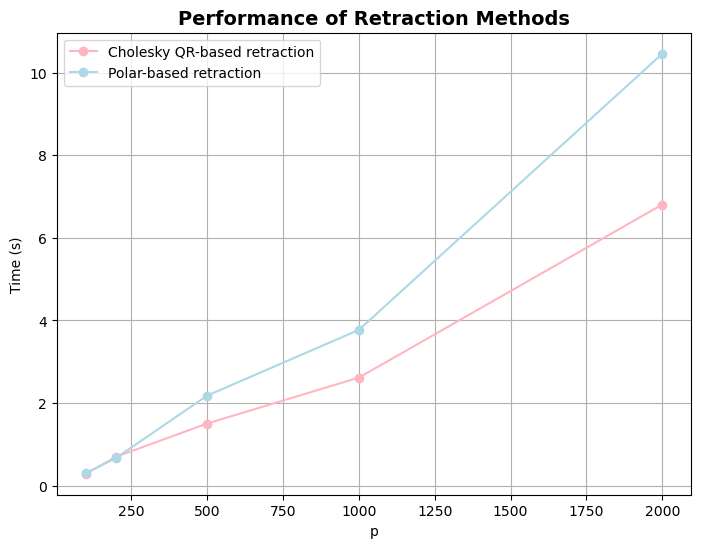

<Figure size 640x480 with 0 Axes>

In [14]:
plot_retraction_performance()

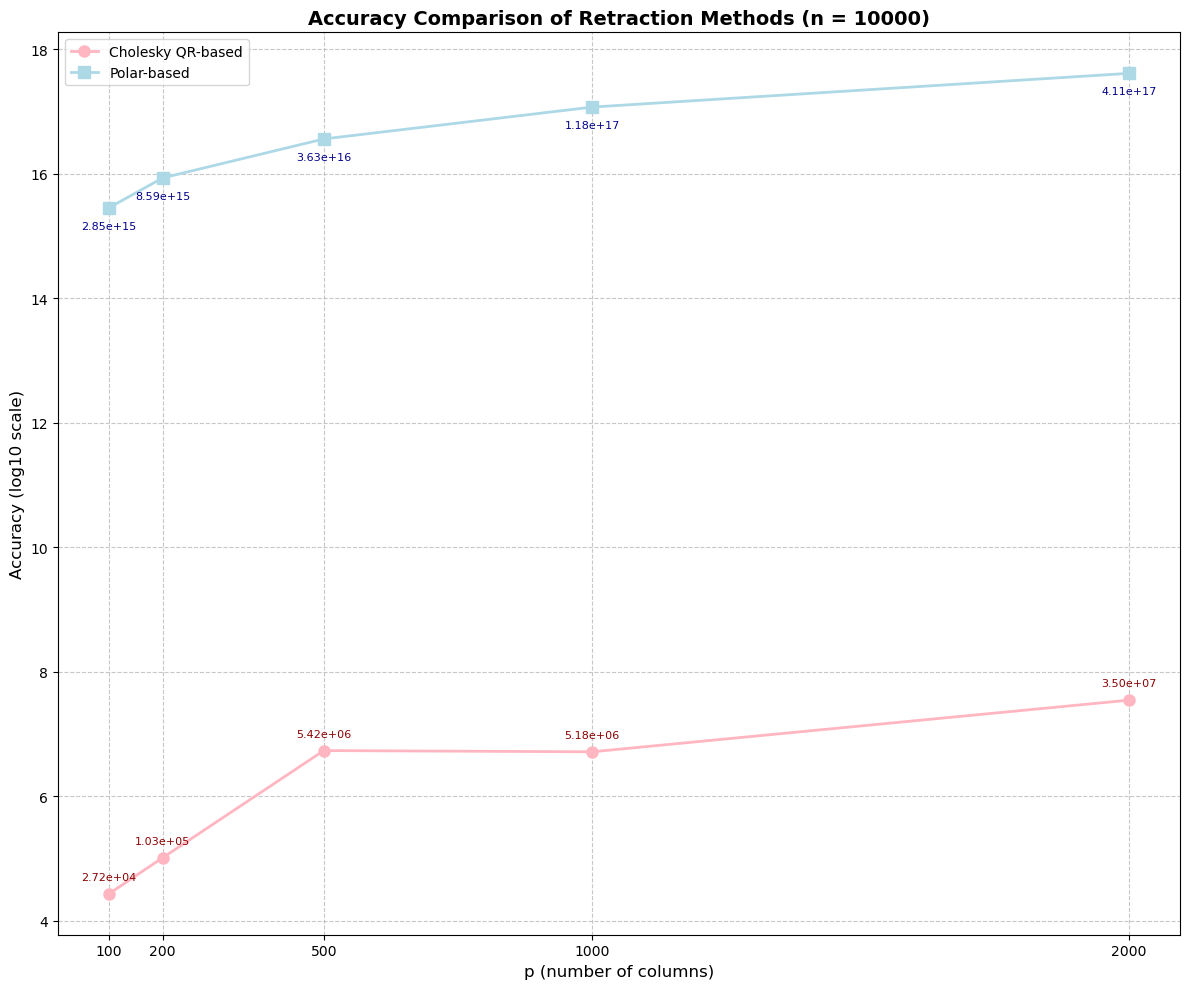

In [18]:

p_values = [100, 200, 500, 1000, 2000]
cholesky_accuracy = [2.72e+04, 1.03e+05, 5.42e+06, 5.18e+06, 3.50e+07]
polar_accuracy = [2.85e+15, 8.59e+15, 3.63e+16, 1.18e+17, 4.11e+17]

# Convert to log scale for better visualization
cholesky_accuracy_log = np.log10(cholesky_accuracy)
polar_accuracy_log = np.log10(polar_accuracy)

plt.figure(figsize=(12, 10))

# Plot Cholesky QR-based retraction accuracy
plt.plot(p_values, cholesky_accuracy_log, 'o-', color='lightpink', linewidth=2, markersize=8, label='Cholesky QR-based')

# Plot Polar-based retraction accuracy
plt.plot(p_values, polar_accuracy_log, 's-', color='lightblue', linewidth=2, markersize=8, label='Polar-based')

plt.xlabel('p (number of columns)', fontsize=12)
plt.ylabel('Accuracy (log10 scale)', fontsize=12)
plt.title('Accuracy Comparison of Retraction Methods (n = 10000)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Customize x-axis ticks
plt.xticks(p_values)

# Add text annotations for exact values
for i, p in enumerate(p_values):
    plt.annotate(f'{cholesky_accuracy[i]:.2e}', (p, cholesky_accuracy_log[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkred')
    plt.annotate(f'{polar_accuracy[i]:.2e}', (p, polar_accuracy_log[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='darkblue')

plt.tight_layout()
plt.savefig('retraction_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


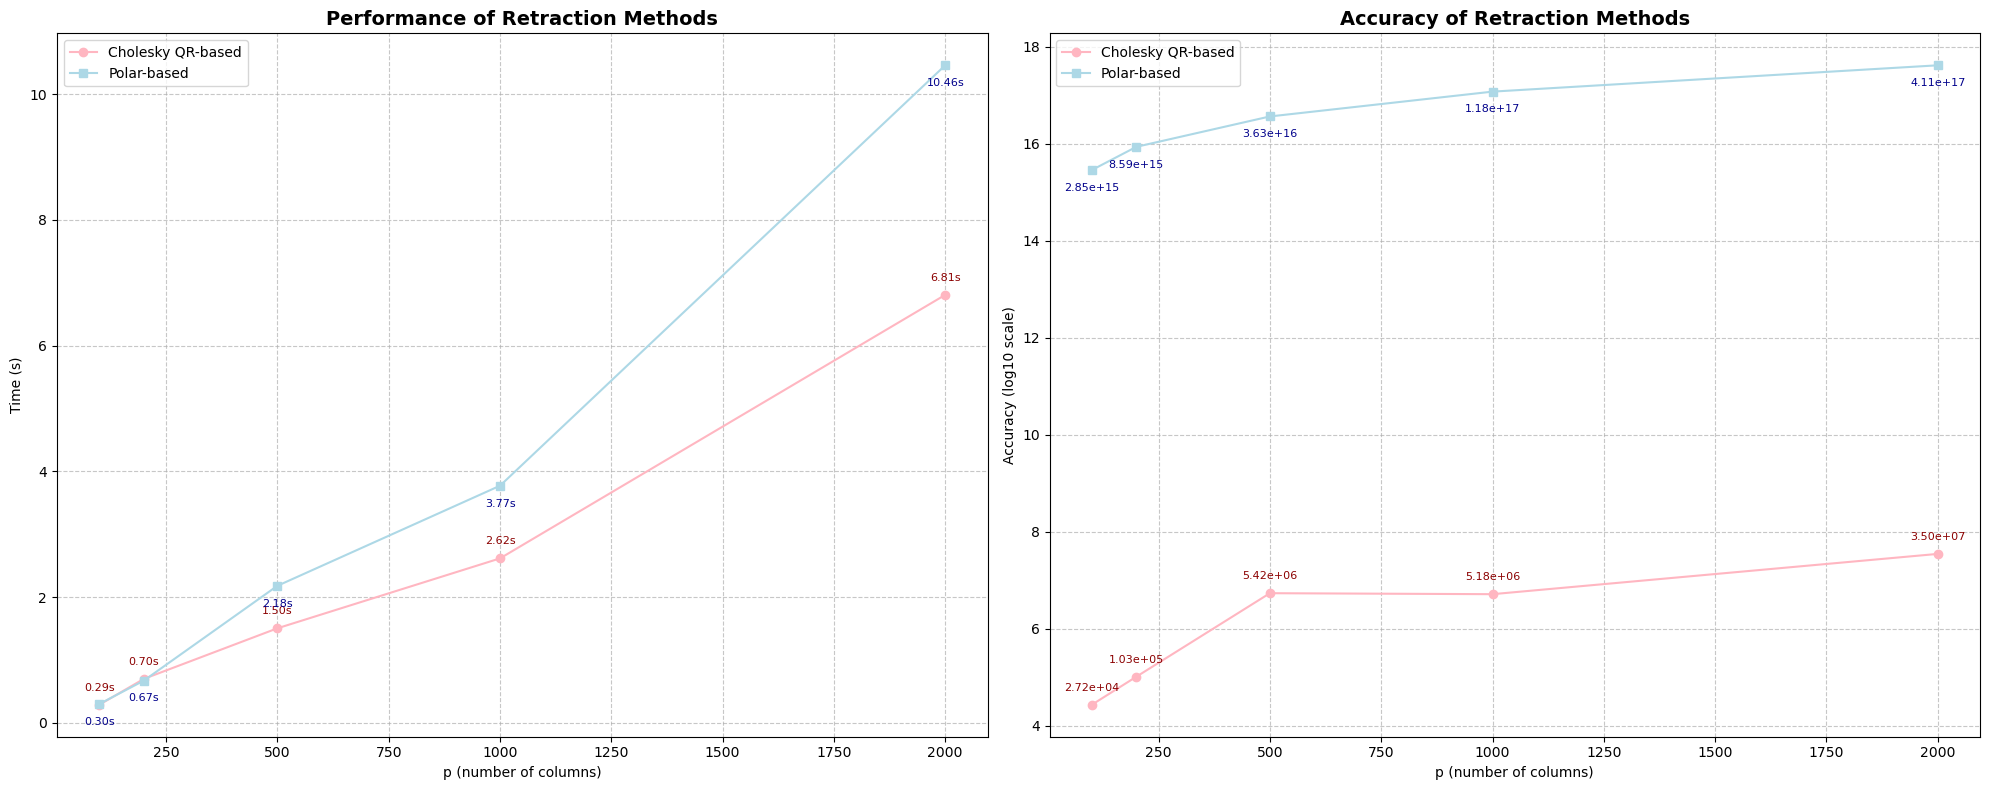

In [19]:

def plot_retraction_comparison():
    # Load data from results.json
    with open("results.json", "r") as file:
        results = json.load(file)

    p_values = []
    chol_times = []
    polar_times = []
    chol_accuracies = []
    polar_accuracies = []

    for key, result in results.items():
        p = int(key.split(", p=")[1])
        p_values.append(p)
        chol_times.append(result["Cholesky QR-based retraction"]["Time"])
        polar_times.append(result["Polar-based retraction"]["Time"])
        chol_accuracies.append(result["Cholesky QR-based retraction"]["Accuracy"])
        polar_accuracies.append(result["Polar-based retraction"]["Accuracy"])

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Performance (Time)
    ax1.plot(p_values, chol_times, "o-", label="Cholesky QR-based", color="lightpink")
    ax1.plot(p_values, polar_times, "s-", label="Polar-based", color="lightblue")
    ax1.set_xlabel("p (number of columns)")
    ax1.set_ylabel("Time (s)")
    ax1.set_title("Performance of Retraction Methods", fontsize=14, fontweight="bold")
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Accuracy (log scale)
    chol_accuracies_log = np.log10(chol_accuracies)
    polar_accuracies_log = np.log10(polar_accuracies)

    ax2.plot(p_values, chol_accuracies_log, "o-", label="Cholesky QR-based", color="lightpink")
    ax2.plot(p_values, polar_accuracies_log, "s-", label="Polar-based", color="lightblue")
    ax2.set_xlabel("p (number of columns)")
    ax2.set_ylabel("Accuracy (log10 scale)")
    ax2.set_title("Accuracy of Retraction Methods", fontsize=14, fontweight="bold")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Add value annotations
    for i, p in enumerate(p_values):
        ax1.annotate(f'{chol_times[i]:.2f}s', (p, chol_times[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkred')
        ax1.annotate(f'{polar_times[i]:.2f}s', (p, polar_times[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='darkblue')
        
        ax2.annotate(f'{chol_accuracies[i]:.2e}', (p, chol_accuracies_log[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkred')
        ax2.annotate(f'{polar_accuracies[i]:.2e}', (p, polar_accuracies_log[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='darkblue')

    plt.tight_layout()
    plt.savefig('retraction_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to create the plot
plot_retraction_comparison()
